In [1]:
## Libraries
import os
import sys
import re
import numpy as np
import pandas as pd
import seaborn as sns
import math
import random
import tools as tl
from coralModel import Reef, Organism, Ocean
import matplotlib.pyplot as plt
import matplotlib.colors as clt
from matplotlib.legend_handler import HandlerPatch
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition

## Functions

class HandlerSquare(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        center = xdescent + 0.5 * (width - height), ydescent
        p = mpatches.Rectangle(xy=center, width=height,
                               height=height, angle=0.0)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p] 
    
def prep_image(df, simulation, timestep):    
    image = df[(df['timestep']==timestep)&(df['simulation']==simulation)]['image']
    image = np.genfromtxt([image.values[0].replace('[', '').replace(']', '')])
    image = np.reshape(image, (25,25))
    return(image)

def create_reef(simulation):
    
    if grid_option == 0:
        
        random.seed(simulation)
        grid = [(i,j)
                for i in range(0, number_of_columns) 
                for j in range(0, number_of_rows)]
        random.shuffle(grid)
        coral_count = round(number_of_nodes*coral_percent)
        macro_count = round(number_of_nodes*macroalgae_percent)
        locations = {'coral': grid[0:coral_count],
                     'macro': grid[coral_count: coral_count + macro_count]}
    elif grid_option == 2:
        type_percent_dictionary = {0:coral_percent, 1:turf_percent, 2:macroalgae_percent}
        blob_percent = type_percent_dictionary[blob_value]
        not_blob = [a for a in [0,1,2] if a != blob_value]
        not_blob_percentages_adjusted = [round(type_percent_dictionary[n]/ 
                                               (1 - blob_percent), 2) for n in not_blob]
        blob_locations = tl.generate_blob(blob_percent, blob_value, 
                                          number_of_rows, number_of_columns, number_of_nodes)
    
    Moorea = Reef()
    count = 0
    for i in range(0, number_of_rows): 
        for j in range(0, number_of_columns):
            if grid_option == 0:  
                if (i,j) in locations['coral']:
                    U = 0
                elif (i,j) in locations['macro']:
                    U = 2
                else:
                    U = 1                   
            elif grid_option == 2:
                if (i,j) in blob_locations:
                    U = blob_value
                else:
                    U = np.random.choice(not_blob, p=not_blob_percentages_adjusted)
            elif grid_option == 3: ##for threshold plotting
                U = 0
            node = Organism(type=U, location=[i,j], ID=count)
            Moorea.append(node)
            count = count + 1
    return(Moorea)

In [2]:
sns.set_style("ticks")

colors = ['#EE8382', '#508991', '#172A3A']
success_palette = sns.set_palette(sns.color_palette(colors))

levels = [0, 1, 2]
legend_keys = ['Coral', 'Turf', 'Macroalgae']
cmap, norm = clt.from_levels_and_colors(levels=levels, colors=colors, extend='max')

In [3]:
path = './figures/paper/1_introduction_figure/'
extension = '.png'

#runs
top_directory = "./output/" #os.getcwd()
files, runs = tl.view_runs(top_directory)

### Random vs Blob

In [4]:
number_of_rows, number_of_columns = 25,25
number_of_nodes = number_of_rows * number_of_columns
coral_percent, macroalgae_percent = float(33)/100, float(33)/100
turf_percent = round(1 - coral_percent - macroalgae_percent, 2)

simulation = 3
blob_value = 0
grid_option = 0
reef_random = create_reef(simulation)
grid_option = 2
reef_blob = create_reef(simulation)

reef_random = np.reshape(np.array([reef_random.nodes[i].type for i,val in enumerate(reef_random.nodes)]),(number_of_rows,number_of_columns))
reef_blob = np.reshape(np.array([reef_blob.nodes[i].type for i,val in enumerate(reef_blob.nodes)]),(number_of_rows,number_of_columns))

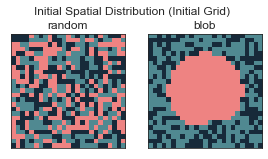

In [7]:
name = 'initial_grid'
def initial_grid_visualization():
    images = [reef_random, reef_blob]
    titles = ["random", "blob"]
    fig, ax = plt.subplots(1,2, figsize=(4.5, 3))  
    fig.suptitle('Initial Spatial Distribution (Initial Grid)')
    
    for index, value in enumerate(images):
        ax[index].imshow(value, cmap=cmap, norm=norm)
        ax[index].set_title(titles[index])
        #ax[index].set_frame_on(False)
        ax[index].set_yticks([])
        ax[index].set_xticks([])
        ax[index].set_frame_on(True)     
    fig.subplots_adjust(top=1.05)
    plt.savefig(path + name + extension, dpi=200)
    plt.show()
initial_grid_visualization()


### Threshold example

In [65]:
thresholds = [1.45, 11]
number_of_rows, number_of_columns = 25,25
number_of_nodes = number_of_rows * number_of_columns
middle_node =  68 #27 #round(rows*rows/2)
simulation = 19

In [66]:
threshold_images = []
grid_option = 3 #specifically for plotting thresholds
reef = create_reef(simulation)

for threshold in thresholds:
    
    reef.generate_graph(threshold)
    neighbors = reef.graph[middle_node]
    
    for neighbor in neighbors:
        reef.nodes[neighbor].type = 1 
        
    reef.nodes[middle_node].type = 2
    
    reef_types = np.array([reef.nodes[i].type for i,val in enumerate(reef.nodes)], dtype=float)   
    threshold_images.append(np.reshape(reef_types, (number_of_rows, number_of_columns)))

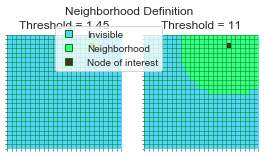

In [78]:
name = 'neighborhood_definition'

def neighborhood_visualization():
    titles = ['Threshold = '+str(thresholds[0]), 
              'Threshold = '+str(thresholds[1])]
    levels = [0, 1, 2]
    colors = ['#51D6FF', '#37FF8B', '#522B29']
    legend_lables = ['Invisible', 'Neighborhood', 'Node of interest']
    cmap, norm = clt.from_levels_and_colors(levels=levels, colors=colors, extend='max')
    
    fig, ax = plt.subplots(1,2, figsize=(4.5,3))  
    fig.suptitle('Neighborhood Definition')

    for index, value in enumerate(threshold_images):
        ax[index].imshow(value, cmap=cmap, norm=norm)#, interpolation='none', aspect='equal') 
        ax[index].set_xticks(np.arange(-.5, number_of_rows, 1), minor=True)
        ax[index].set_yticks(np.arange(-.5, number_of_rows, 1), minor=True)
        ax[index].set_yticks([])
        ax[index].set_xticks([])
        ax[index].set_frame_on(False)
        ax[index].grid(color='green', linestyle='-', linewidth=.5, which='minor')
        ax[index].set_title(titles[index])

    patches = [mpatches.Patch(facecolor=colors[i], edgecolor="green", label=legend_lables[i]) for i in levels]
    fig.legend(handles=patches, bbox_to_anchor=(.50, .60), borderaxespad=0., handler_map={patches[i]:HandlerSquare() for i in levels})
    fig.subplots_adjust(top=1.05)
    plt.savefig(path + name + extension, dpi=200)
    plt.show()


neighborhood_visualization()

In [10]:
grazing = 57
subset = runs[(runs['neighborhood_threshold']==145)&
              (runs['number_of_rows']==25)&
              (runs['grazing']==grazing)&
              (runs['grid_option']==0)]
subset

,number_of_rows,number_of_columns,grid_option,grazing,neighborhood_threshold,initial_coral_percent,initial_macroalgae_percent,r,d,a,y,number_of_timesteps,record_rate,number_of_simulations,file
0,25,25,0,57,145,33,33,10,40,20,75,1100,10,10,0


In [11]:
df = tl.load_runs(files, subset)
df = tl.split_neighbors(df)
df = tl.add_percent(df)
df['time'] = df['timestep']*.1
df['time'] = df['time'].astype('int')

In [12]:
dfplot = df.copy()
dfplot = dfplot.rename(columns={'coral_percent':'coral','macroalgae_percent':'macroalgae','turf_percent':'turf'})
df_to_melt = dfplot[['coral','timestep', 'time', 'simulation', 'macroalgae', 'turf']]
df_melted = pd.melt(df_to_melt, id_vars=['timestep','time','simulation'], value_vars=['coral', 'turf','macroalgae'])
df_melted.head()

,timestep,time,simulation,variable,value
0,0,0,0,coral,32.96
1,10,1,0,coral,34.40
2,20,2,0,coral,33.44
3,30,3,0,coral,32.80
4,40,4,0,coral,32.96


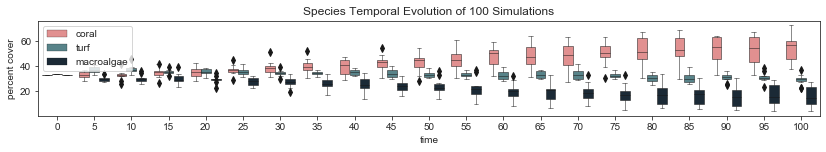

In [13]:
name ='boxplot_temporal_evolution'

timesteps = [0, 50, 100, 150, 200, 250, 300, 350, 400, 
             450, 500, 550, 600, 650, 700, 750, 800, 
             850, 900, 950, 1000]

plt.figure(figsize=(14,1.75))
fig = sns.boxplot(x="time", y="value", hue="variable", 
            data=df_melted[df_melted['timestep'].isin(timesteps)], palette=success_palette,
            linewidth=.5)
plt.title('Species Temporal Evolution of 100 Simulations')
plt.legend(loc='upper left')
plt.ylabel("percent cover")
plt.savefig(path + name + extension, dpi=200, bbox_inches = "tight")

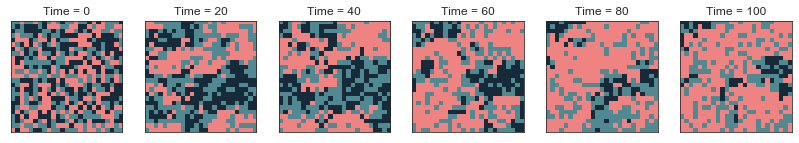

In [14]:
name = 'spatial_evolution_images'

simulation = 1
timesteps = [0, 200, 400, 600, 800, 1000]

fig, ax = plt.subplots(1, len(timesteps), figsize=(14,4)) 

for index in range(0, len(timesteps)):    
    image = prep_image(df,simulation,timesteps[index])    
    ax[index].imshow(image, cmap=cmap, norm=norm)
    ax[index].set_title('Time = ' + str(int(timesteps[index]*.1)))
    ax[index].axes.xaxis.set_visible(False)
    ax[index].axes.yaxis.set_visible(False)
    #ax[index].set_frame_on(False)
fig.subplots_adjust(wspace=0.2, top=.75)
plt.savefig(path + name + extension, dpi=400)


### Zoomed-in example

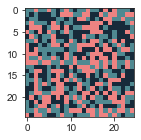

In [15]:
name = 'example_grid'


image = prep_image(df, simulation=simulation, timestep=0)
plt.figure(figsize=(2,2))
plt.imshow(image, cmap=cmap, norm=norm)
#plt.legend(handles=patches, bbox_to_anchor=(.99, .7), borderaxespad=0.,
#           handler_map={patches[i]:HandlerSquare() for i in levels})
plt.savefig(path + name + extension, dpi=400)

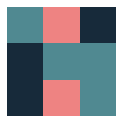

In [16]:
name = 'example_zoom'

fig = plt.figure(figsize=(2,2))

image = prep_image(df, simulation=simulation, timestep=0)
#plt.yticks(np.arange(-.5, number_of_rows, 1), minor=True)
#plt.yticks(np.arange(-.5, number_of_rows, 1), minor=True)
plt.yticks([])
plt.xticks([])
plt.box(False)
ax[index].grid(color='green', linestyle='-', linewidth=.5, which='minor')
plt.imshow(image, cmap=cmap, norm=norm)

    
#plt.legend(handles=patches, bbox_to_anchor=(.99, .7), borderaxespad=0.,
#           handler_map={patches[i]:HandlerSquare() for i in levels})
plt.axis((16.5,19.5,15.5,12.5))
plt.savefig(path + name + extension, dpi=400)